## 1. Dependencis

In [23]:
# utils 
import gc
import os
import json 
import random
import warnings
from tqdm.notebook import tqdm
from copy import copy, deepcopy


# data and vis
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# model and evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, auc, roc_curve, precision_recall_curve, make_scorer, accuracy_score, precision_score, recall_score, f1_score

In [24]:
### set seed
random.seed(43)
np.random.seed(43)

In [25]:
# set seaborn plot style as darkgrid, which looks very good to me.
sns.set_style("darkgrid")

In [26]:
# to ignore the warning
warnings.filterwarnings(action="ignore")

## 2. Preprocessing and EDA

In [29]:
### Reading the dataset
df = pd.read_csv("./data/data_interview_test.csv", header=0, low_memory=False, delimiter = ':')

In [30]:
# see the type and null entries in the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12034 entries, 0 to 12033
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   receipt_id               12034 non-null  object 
 1   company_id               12034 non-null  int64  
 2   matched_transaction_id   12034 non-null  object 
 3   feature_transaction_id   12034 non-null  object 
 4   DateMappingMatch         12034 non-null  float64
 5   AmountMappingMatch       12034 non-null  float64
 6   DescriptionMatch         12034 non-null  float64
 7   DifferentPredictedTime   12034 non-null  float64
 8   TimeMappingMatch         12034 non-null  float64
 9   PredictedNameMatch       12034 non-null  float64
 10  ShortNameMatch           12034 non-null  float64
 11  DifferentPredictedDate   12034 non-null  float64
 12  PredictedAmountMatch     12034 non-null  float64
 13  PredictedTimeCloseMatch  12034 non-null  float64
dtypes: float64(10), int64(

In [31]:
# fields in the dataset and types
df.head()

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch
0,"10,000",10000,"10,468","10,000",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,"10,000",10000,"10,468","10,001",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,"10,000",10000,"10,468","10,003",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,"10,000",10000,"10,468","10,004",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,"10,000",10000,"10,468","10,005",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


### Ground Truth / Labels
- As per problem statement match is correct if `matched_transaction_id` is same as `feature_transaction_id`

In [32]:
df['target']= df['matched_transaction_id'] == df['feature_transaction_id']

In [33]:
df['target'] = df['target'].astype("int") # convert the bool into int 

In [34]:
df['target'].value_counts()

0    11177
1      857
Name: target, dtype: int64

#### Normalzied Label Distribution

In [35]:
df['target'].value_counts().apply(lambda x:(x/df.shape[0])*100)

0    92.878511
1     7.121489
Name: target, dtype: float64

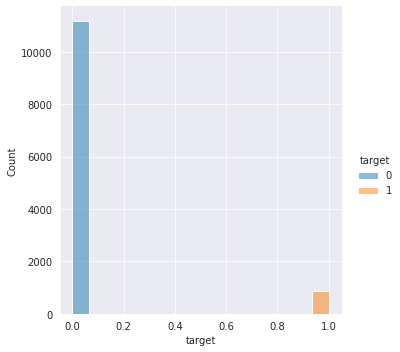

In [36]:
# visualize the barplot of label distribution
sns.displot(
    data=df,
    x='target',
    hue='target'
)

#### <font color='red'>**Data Imabalenced:** Data is highly imabaleced, accuracy and BCE (in case of NN and SGD optimization) might not be correct metrics and loss function to asses to model, points to consider before cosidering an evaluation metrics</font>
    1. What's the stake if our model missclassifies matched label (1) as mismatched?
    2. What's the stake if our model missclassifies mismatched label(0) as matched?
From the problem statement it appears that stake in 2nd case is higher hence our model should correctly classify the max possible `mismiatched` label, which means we have to have high recall `TP/(TP+FN)` for neg class.


In [37]:
df.head(2)

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch,target
0,"10,000",10000,"10,468","10,000",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,"10,000",10000,"10,468","10,001",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0


In [38]:
# drop the meta entries which are not features
df = df.drop(columns=['receipt_id', 'company_id', 'matched_transaction_id', 'feature_transaction_id'])

In [39]:
df.head(2)

,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch,target
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0


In [40]:
# see the stats of features (Do we need to scale the features or not?)
df.describe()

,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch,target
count,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000
mean,0.217901,0.031660,0.021522,0.986455,0.013877,0.024215,0.037893,0.753532,0.001005,0.076533,0.071215
std,0.384535,0.122611,0.116995,0.115597,0.116987,0.128646,0.190945,0.430972,0.020134,0.265860,0.257194
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,0.900000,0.800000,1.000000,1.000000,0.800000,1.000000,1.000000,0.600000,1.000000,1.000000


#### Holding some data to evaluate all models on same set 

In [22]:
y = df['target']

In [23]:
 # hold 10% of to evaluate the model, stratefield split 
 df_train, df_test, _, _  = train_test_split(
     df,
     y,
     test_size=0.10,
     stratify=y
 )

In [24]:
print(f'df_train.shape = {df_train.shape} || df_test.shape = {df_test.shape}')

df_train.shape = (10830, 11) || df_test.shape = (1204, 11)


In [25]:
### Evalute the label distribution again for test and train df
df_train['target'].value_counts().apply(lambda x:(x/df_train.shape[0])*100)

0    92.880886
1     7.119114
Name: target, dtype: float64

In [26]:
# for hold out test set
df_test['target'].value_counts().apply(lambda x:(x/df_test.shape[0])*100)

0    92.857143
1     7.142857
Name: target, dtype: float64

In [27]:
## save the data
df_train.to_csv("./data/train.csv", index=False)
df_test.to_csv("./data/test.csv", index=False)

## 3. Modelling and Evaluation
- StratefiedKFold validation k=5
- Class Weight for Imabalanced Classification
- Following metrics is used to asses the models' performance
    - Precision =  `(TP/(TP+FP))`
    - Recall  = `(TP/(TP+FN))`
    - F1 

- Models
    1. Support Vector Machine
    2. Random Forest
    3. XGBoost
    4. Ensembling
    5. XTabNet 
    6. TabNet
    

In [5]:
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")

In [6]:
# features values from dataframe
y = train_df['target'].values
X = train_df.drop(columns=["target"]).values

In [7]:
print(f'X.shape = {X.shape} || y.shape = {y.shape}')

X.shape = (10830, 10) || y.shape = (10830,)


#### Training function to fit any sklearn classifier

In [8]:
def train(clf, X, y, model, ax, n_folds=10, random_state=42):

    # create model dir inside the results to store everything 
    path = os.path.join(os.getcwd(), "results", model)
    os.makedirs(path, exist_ok=True)


    # corss validation
    kfold = StratifiedKFold(n_splits=n_folds, shuffle=False)

    
    training_logs = {}

    clf_ = deepcopy(clf)

    accuracy  = []
    precison = []
    recall = []
    f1 = []
    aucs = []
    
    y_real = []
    y_predicted = []
    y_proba = []

    # iterate over each fold
    for i, (train, valid) in tqdm(enumerate(kfold.split(X=X, y=y))):

        clf = deepcopy(clf_)

        # fit the model
        clf.fit(X[train], y[train])

        # make prediction and predicted probs
        y_true = y[valid]
        y_pred = clf.predict(X[valid])
        probs = clf.predict_proba(X[valid])

        # compute metrics
        accuracy.append(accuracy_score(y_true=y_true, y_pred=y_pred))
        precison.append(precision_score(y_true=y_true, y_pred=y_pred, average="binary"))
        recall.append(recall_score(y_true=y_true, y_pred=y_pred, average="binary"))
        f1.append(f1_score(y_true=y_true, y_pred=y_pred, average="binary"))

        # precision recall curve 
        p, r, th = precision_recall_curve(y_true=y_true, probas_pred=probs[:, 1])

        # computing area under the curreve 
        aread_under_curve = auc(r, p)

        aucs.append(aread_under_curve)

        label = 'Fold %d AUC=%.4f' % (i+1, aread_under_curve)

        ax.step(r, p, label=label)

        y_real.append(y_true)
        y_predicted.append(y_pred)
        y_proba.append(probs[:, 1])



        # get classification report which will be stored 
        cr = classification_report(y_true=y_true, y_pred=y_pred, digits=4)
        # save classification report  
        with open(os.path.join(path, "fold-"+str(i+1)+".txt"), "w") as file:
            file.write(cr)


        # confusion matrix
        # cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
        # a = sns.heatmap(cm, annot=True, fmt=".0f")
        # plt.margins(0,0)
        # plt.savefig(os.path.join(os.getcwd(), "results", model, "fold_"+str(i+1)+"_cm.png"), bbox_inches = 'tight', pad_inches = 0)
        # del a
    

    y_real = np.concatenate(y_real)
    y_predicted = np.concatenate(y_predicted)
    y_proba = np.concatenate(y_proba)
    precision, recall, _ = precision_recall_curve(y_real, y_proba)
    lab = 'Overall AUC=%.4f' % (auc(recall, precision))
    ax.step(recall, precision, label=lab, lw=2, color='black')

    # classificatio for all data
    cr = classification_report(y_true=y_real, y_pred=y_predicted, digits=4)
    # save the final report
    with open(os.path.join(path, "combined.txt"), "w") as file:
        file.write(cr)

    
    cm = confusion_matrix(y_true=y_real, y_pred=y_predicted)

    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.legend(loc='lower left', fontsize='small')

    
    results = {
        "accuracy":{
            "mean":np.round(np.mean(accuracy), 4)*100,
            "std":np.round(np.std(accuracy), 4)*100,
        },
        "precision":{
            "mean":np.round(np.mean(precison), 4)*100,
            "std":np.round(np.std(precison), 4)*100,
        },
        "recall":{
            "mean":np.round(np.mean(recall), 4)*100,
            "std":np.round(np.std(recall), 4)*100,
        },
        "f1":{
            "mean":np.round(np.mean(f1), 4)*100,
            "std":np.round(np.std(f1), 4)*100,
        },
        "auc":{
            "mean":np.round(np.mean(aucs), 4)*100,
            "std":np.round(np.std(aucs), 4)*100,
        }
    }

    # save the final results
    with open(os.path.join(path, "results.json"), "w") as file:
        json.dump(results, file)

    return results, cm, ax


### 2. Support Vector Machine Classifier

In [67]:
from sklearn.svm import SVC

In [76]:
model = "SVM"

In [77]:
clf = SVC(verbose=False, probability=True, class_weight={1: 2}) # class weight for imabal

0it [00:00, ?it/s]

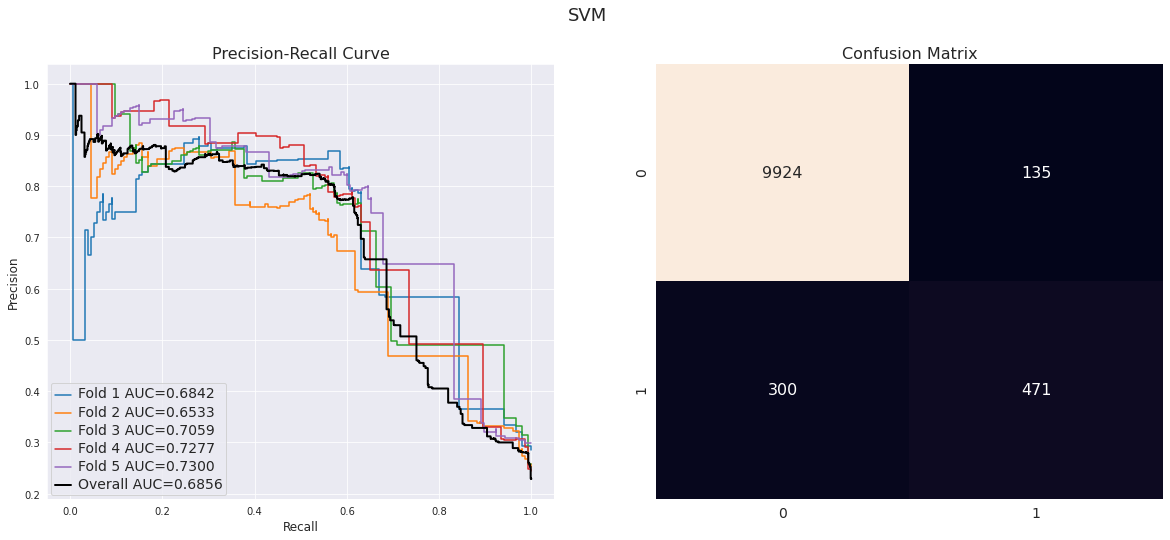

In [82]:
# create subplots
f, ax = plt.subplots(1, 2, figsize=(20, 8))

# train the model 
results, cm, ax[0] = train(clf=clf, X=X, y=y, model=model, n_folds=5, ax=ax[0])

# set legend pos
ax[0].legend(loc='lower left', fontsize='small')

# increase the font size of subplot (for pr curve)
ax[0].set_title("Precision-Recall Curve", fontsize=16)

# plot confusion matrix in 2nd subplot
sns.heatmap(cm, annot=True, cbar=False, fmt=".0f", ax=ax[1], annot_kws={'size':16})

# change the font size and save the fig
ax[1].set_title("Confusion Matrix", fontsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=14) 
plt.setp(ax[0].get_legend().get_texts(), fontsize=14) # for legend text
plt.setp(ax[0].get_legend().get_title(), fontsize=14) # for legend title
plt.suptitle(model, fontsize=18)
plt.margins(0,0)
plt.savefig(os.path.join(os.getcwd(), "results", model, model+"_pr_curve.png"), bbox_inches = 'tight', pad_inches = 0)
plt.show()

### 2. Random Forest Classifier

In [83]:
from sklearn.ensemble import RandomForestClassifier

In [84]:
model = "RFC"

In [85]:
clf = RandomForestClassifier(n_estimators=1000, verbose=False, class_weight={1:2})

0it [00:00, ?it/s]

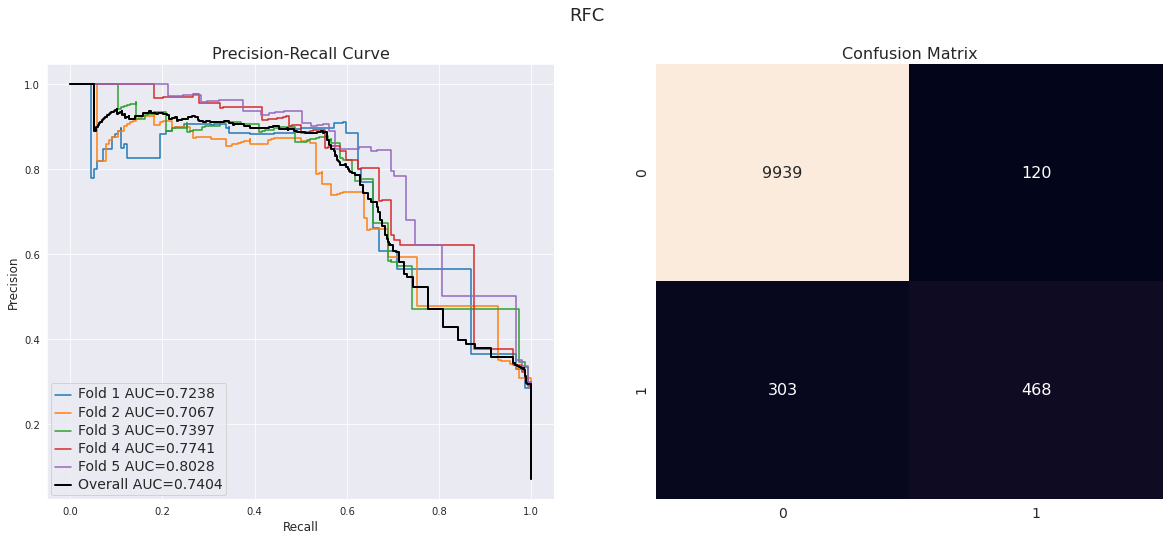

In [86]:
# create subplots
f, ax = plt.subplots(1, 2, figsize=(20, 8))

# train the model 
results, cm, ax[0] = train(clf=clf, X=X, y=y, model=model, n_folds=5, ax=ax[0])

# set legend pos
ax[0].legend(loc='lower left', fontsize='small')

# increase the font size of subplot (for pr curve)
ax[0].set_title("Precision-Recall Curve", fontsize=16)

# plot confusion matrix in 2nd subplot
sns.heatmap(cm, annot=True, cbar=False, fmt=".0f", ax=ax[1], annot_kws={'size':16})

# change the font size and save the fig
ax[1].set_title("Confusion Matrix", fontsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=14) 
plt.setp(ax[0].get_legend().get_texts(), fontsize=14) # for legend text
plt.setp(ax[0].get_legend().get_title(), fontsize=14) # for legend title
plt.suptitle(model, fontsize=18)
plt.margins(0,0)
plt.savefig(os.path.join(os.getcwd(), "results", model, model+"_pr_curve.png"), bbox_inches = 'tight', pad_inches = 0)
plt.show()

### 3. XGBoost

In [87]:
from xgboost import XGBClassifier

In [88]:
model = "XGBoost"

In [89]:
clf = XGBClassifier(n_estimators=500, verbosity=0, scale_pos_weight=3)

0it [00:00, ?it/s]

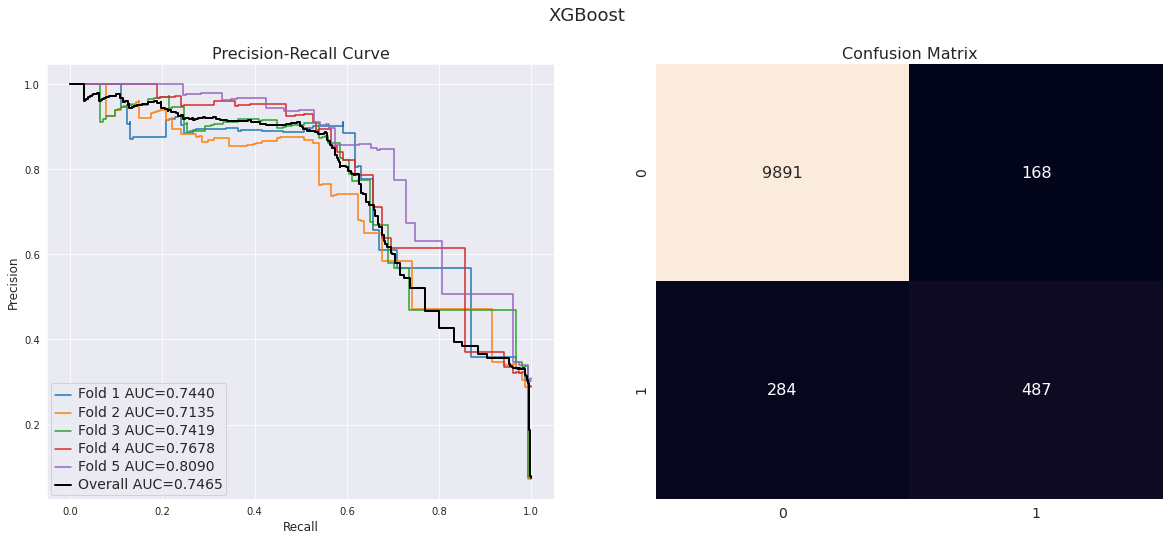

In [90]:
# create subplots
f, ax = plt.subplots(1, 2, figsize=(20, 8))

# train the model 
results, cm, ax[0] = train(clf=clf, X=X, y=y, model=model, n_folds=5, ax=ax[0])

# set legend pos
ax[0].legend(loc='lower left', fontsize='small')

# increase the font size of subplot (for pr curve)
ax[0].set_title("Precision-Recall Curve", fontsize=16)

# plot confusion matrix in 2nd subplot
sns.heatmap(cm, annot=True, cbar=False, fmt=".0f", ax=ax[1], annot_kws={'size':16})

# change the font size and save the fig
ax[1].set_title("Confusion Matrix", fontsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=14) 
plt.setp(ax[0].get_legend().get_texts(), fontsize=14) # for legend text
plt.setp(ax[0].get_legend().get_title(), fontsize=14) # for legend title
plt.suptitle(model, fontsize=18)
plt.margins(0,0)
plt.savefig(os.path.join(os.getcwd(), "results", model, model+"_pr_curve.png"), bbox_inches = 'tight', pad_inches = 0)
plt.show()

### 4. Stacked Model

In [12]:
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

In [13]:
model = "Ensemble"

In [14]:
estimators = [
    ("knn", KNeighborsClassifier(11)),
    # ("gpc", GaussianProcessClassifier(1.0 * RBF(1.0))),
    ("rf", RandomForestClassifier(max_depth=5, n_estimators=20, max_features=1)),
    # ("adbc", AdaBoostClassifier()),
    ("gnb", GaussianNB()),
    ("gbc", GradientBoostingClassifier())
    ]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

0it [00:00, ?it/s]

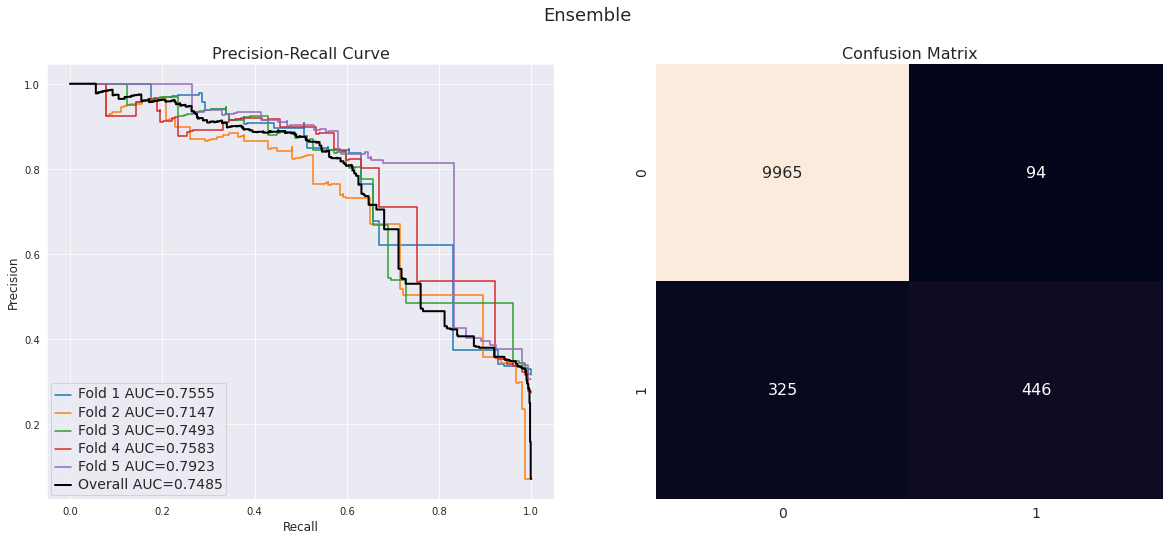

In [15]:
# create subplots
f, ax = plt.subplots(1, 2, figsize=(20, 8))

# train the model 
results, cm, ax[0] = train(clf=clf, X=X, y=y, model=model, n_folds=5, ax=ax[0])

# set legend pos
ax[0].legend(loc='lower left', fontsize='small')

# increase the font size of subplot (for pr curve)
ax[0].set_title("Precision-Recall Curve", fontsize=16)

# plot confusion matrix in 2nd subplot
sns.heatmap(cm, annot=True, cbar=False, fmt=".0f", ax=ax[1], annot_kws={'size':16})

# change the font size and save the fig
ax[1].set_title("Confusion Matrix", fontsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=14) 
plt.setp(ax[0].get_legend().get_texts(), fontsize=14) # for legend text
plt.setp(ax[0].get_legend().get_title(), fontsize=14) # for legend title
plt.suptitle(model, fontsize=18)
plt.margins(0,0)
plt.savefig(os.path.join(os.getcwd(), "results", model, model+"_pr_curve.png"), bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [16]:
results

{'accuracy': {'mean': 96.13000000000001, 'std': 0.27},
 'precision': {'mean': 82.78, 'std': 3.94},
 'recall': {'mean': 66.51, 'std': 35.35},
 'f1': {'mean': 68.03, 'std': 2.16},
 'auc': {'mean': 75.4, 'std': 2.4699999999999998}}

### 5. Training a Neural Model for Tabular Data
- TabNet: https://github.com/dreamquark-ai/tabnet
- Paper: https://arxiv.org/pdf/1908.07442.pdf

In [17]:
from pytorch_tabnet.tab_model import TabNetClassifier

In [18]:
model = "TabNet"

In [20]:
clf = TabNetClassifier(seed=43, verbose=0)

0it [00:00, ?it/s]

No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


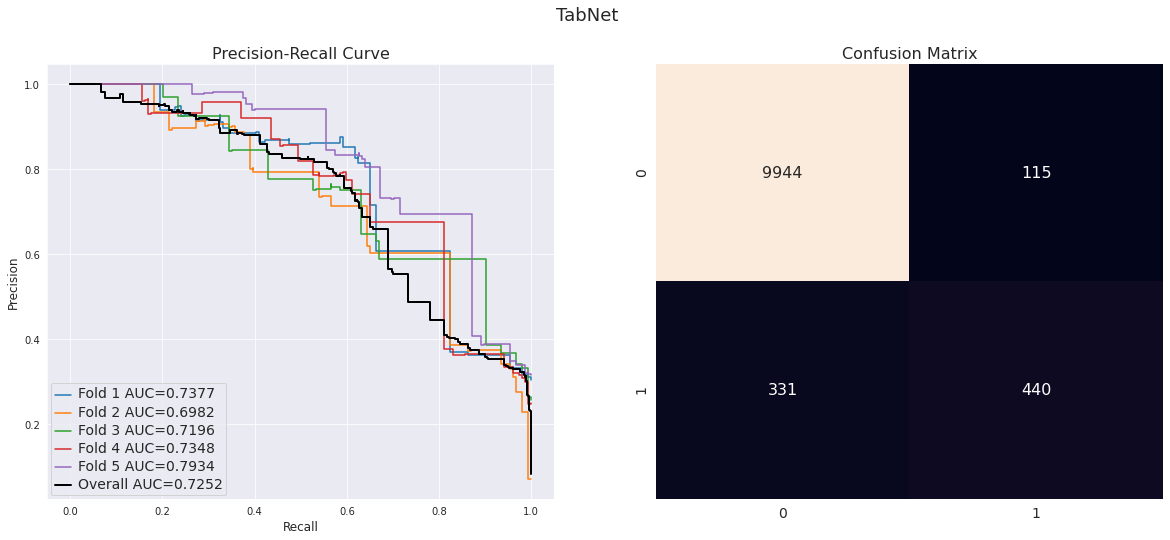

In [21]:
# create subplots
f, ax = plt.subplots(1, 2, figsize=(20, 8))

# train the model 
results, cm, ax[0] = train(clf=clf, X=X, y=y, model=model, n_folds=5, ax=ax[0])

# set legend pos
ax[0].legend(loc='lower left', fontsize='small')

# increase the font size of subplot (for pr curve)
ax[0].set_title("Precision-Recall Curve", fontsize=16)

# plot confusion matrix in 2nd subplot
sns.heatmap(cm, annot=True, cbar=False, fmt=".0f", ax=ax[1], annot_kws={'size':16})

# change the font size and save the fig
ax[1].set_title("Confusion Matrix", fontsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=14) 
plt.setp(ax[0].get_legend().get_texts(), fontsize=14) # for legend text
plt.setp(ax[0].get_legend().get_title(), fontsize=14) # for legend title
plt.suptitle(model, fontsize=18)
plt.margins(0,0)
plt.savefig(os.path.join(os.getcwd(), "results", model, model+"_pr_curve.png"), bbox_inches = 'tight', pad_inches = 0)
plt.show()

## 5. Training H2O Model

In [19]:
import h2o
from h2o.automl import H2OAutoML

In [21]:
# initizlie the h2o instance
h2o.init(max_mem_size='14G')

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_292"; OpenJDK Runtime Environment (build 1.8.0_292-8u292-b10-0ubuntu1~20.04-b10); OpenJDK 64-Bit Server VM (build 25.292-b10, mixed mode)
  Starting server from /home/macab/miniconda3/envs/genbu/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpjg2imv5o
  JVM stdout: /tmp/tmpjg2imv5o/h2o_macab_started_from_python.out
  JVM stderr: /tmp/tmpjg2imv5o/h2o_macab_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.2
H2O_cluster_version_age:,1 month and 13 days
H2O_cluster_name:,H2O_from_python_macab_71hfe8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,12.44 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


In [22]:
data = h2o.import_file("./data/train.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [24]:
data.head(5)

DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch,target
0.95,0,0,1,0,0,0,0,0,1,0
0,0,0,1,0,0,0,1,0,0,0
0,0,0,1,0,0,0,1,0,0,0
0,0.4,0,1,0,0,0,1,0,0,0
0,0,0,1,0,0,0,1,0,0,0


In [27]:
# split the data into train, test and eval sets (we will merge the eval and set to evaluate the model)
train, test, valid = data.split_frame(ratios=[0.80, 0.10])
print(train.shape, valid.shape, test.shape)

(8635, 11) (1078, 11) (1117, 11)


In [28]:
# feature name in datafram
x = train.col_names
x.remove("target")
y = "target"

#### Create and Train H2O AutoModel

In [29]:
# creating the h2o model with fixed configuration
aml = H2OAutoML(max_models=100, seed=47, max_runtime_secs=3600)

In [30]:
# train the model on train dataset
aml.train(x=x, y=y, training_frame=train)                             #

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [22]:
### See the leaderboard (top models)
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

#### Mergin the test and val to create combined eval set

In [33]:
eval = test.rbind(valid)
print(test.shape, valid.shape, eval.shape)

(1117, 11) (1078, 11) (2195, 11)


### Make Predictions on eval set

In [34]:
preds = aml.predict(eval)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [36]:
preds_label = preds > 0.5
print(classification_report(y_true=h2o.as_list(eval)[y].values, y_pred=h2o.as_list(preds_label)['predict'].values, digits=4))

              precision    recall  f1-score   support

           0     0.9683    0.9931    0.9805      2030
           1     0.8761    0.6000    0.7122       165

    accuracy                         0.9636      2195
   macro avg     0.9222    0.7966    0.8464      2195
weighted avg     0.9614    0.9636    0.9604      2195



#### Results are pretty much inline with standard sklearn models 

<AxesSubplot:title={'center':'h2o model classification report default threshold'}>

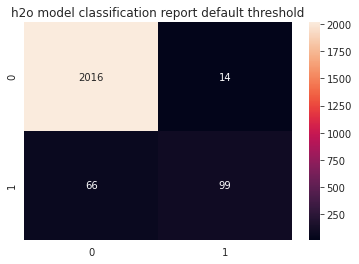

In [37]:
mat = confusion_matrix(y_true=h2o.as_list(eval)[y].values, y_pred=h2o.as_list(preds_label)['predict'].values)
# print("h2o model")
plt.title("h2o model classification report default threshold")
sns.heatmap(mat, annot=True, fmt=".0f")
# plt.savefig("confusion-matrix-random-forest-new-data.jpg")

#### Threshold Tuning to improve the results

In [38]:
# gt and predicted probs
y = h2o.as_list(eval)['target'].values
probs = h2o.as_list(preds)['predict'].values

In [39]:
precision, recall, thresholds = precision_recall_curve(y_true=y, probas_pred=probs)

In [53]:
print(f'H2O AUC Score = {auc(recall, precision)*100:.2f}')

H2O AUC Score = 77.33


### Move the threshold such that geormetic mean of precision and recall is maximum

In [57]:
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold = %.4f, F-Score = %.4f' % (thresholds[ix], fscore[ix]))

Best Threshold = 0.5395, F-Score = 0.7122


In [58]:
# random model
no_skill = len(y[y==1]) / len(y)

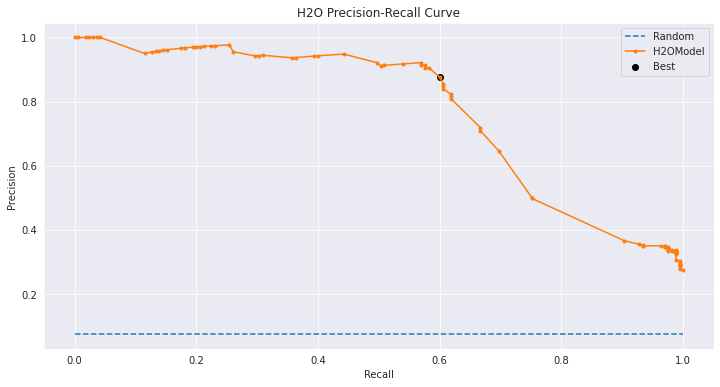

In [63]:
plt.figure(figsize=(12, 6))
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='Random')
plt.plot(recall, precision, marker='.', label='H2OModel')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("H2O Precision-Recall Curve")

plt.legend()
# show the plot
plt.show()

### Classification Report with Best Threshold

In [64]:
preds_label = probs > 0.5395

In [66]:
print(f'H2O model classification report with best threshold = {0.5395:.4f}\n')
print(classification_report(y_true=y, y_pred=preds_label, digits=4))

H2O model classification report with best threshold = 0.5395

              precision    recall  f1-score   support

           0     0.9670    0.9951    0.9808      2030
           1     0.9057    0.5818    0.7085       165

    accuracy                         0.9640      2195
   macro avg     0.9363    0.7884    0.8447      2195
weighted avg     0.9624    0.9640    0.9603      2195



H2O model confusion matrix with best threshold = 0.5395



<AxesSubplot:>

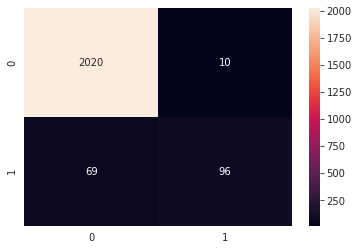

In [67]:
mat = confusion_matrix(y_true=y, y_pred=preds_label)
print(f'H2O model confusion matrix with best threshold = {0.5395:.4f}\n')
sns.heatmap(mat, annot=True, fmt=".0f")
# plt.savefig("confusion-matrix-random-forest-new-data.jpg")

### Note:
- Results remains pretty much same as default threshold
- Prediction is heavily skewed towards majority class this is why we're witnessing low recall for minority class
- A possible fix to this probs is to use more calibrated loss function that penalizes the minority class misclassification than the majority class.

#### Save/Load the model for inference

In [68]:
# save the model ./models/ subdir
model_path = h2o.save_model(model=aml.get_best_model(), path="./models/", force=True)

In [69]:
model = h2o.load_model(model_path)

In [71]:
# classifiy the prediction
preds_label = preds > 0.5

In [82]:
# preds_label

In [80]:
# prediction by saved model
print(classification_report(y_true=h2o.as_list(eval)['target'].values, y_pred=h2o.as_list(preds_label)['predict'].values))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2030
           1       0.88      0.60      0.71       165

    accuracy                           0.96      2195
   macro avg       0.92      0.80      0.85      2195
weighted avg       0.96      0.96      0.96      2195

